# MA 592 Project

## Import Data


In [1]:
from scipy.io import mmread
# Read Count Matrix data and names

# counts_mat = mmread("./CD14_mtxs/CD14_counts.mtx").todense()
counts_mat = mmread("./dataset_norm/CD14_norm_counts.mtx").todense()
# with open("./CD14_mtxs/CD14_c_colnames.txt", 'r') as f:
with open("./dataset_norm/CD14_norm_c_colnames.txt", 'r') as f:
    counts_rownames = [x[:-1] for x in f.readlines()]
# with open("./CD14_mtxs/CD14_c_rownames.txt", 'r') as f:
with open("./dataset_norm/CD14_norm_c_rownames.txt", 'r') as f:
    counts_colnames = [x[:-1] for x in f.readlines()]

# Read Pertubation Matrix data and names

# pert_mat = mmread("./CD14_mtxs/CD14_perturbations.mtx").todense()
pert_mat = mmread("./dataset_norm/CD14_norm_p.mtx").todense()
# with open("./CD14_mtxs/CD14_p_colnames.txt", 'r') as f:
with open("./dataset_norm/CD14_norm_p_colnames.txt", 'r') as f:
    pert_rownames = [x[:-1] for x in f.readlines()]
# with open("./CD14_mtxs/CD14_p_rownames.txt", 'r') as f:
with open("./dataset_norm/CD14_norm_p_rownames.txt", 'r') as f:
    pert_colnames = [x[:-1] for x in f.readlines()]


## Conversion to Pandas Dataframe

In [2]:
import numpy as np
import pandas as pd

# Make Counts Dataframe
counts_df = pd.DataFrame(data=counts_mat.transpose(), columns=counts_colnames)
# Insert proteins by rowname as first column
counts_df.insert(loc=0, column="Cell", value=counts_rownames)

# Same process for perturbations
pert_df = pd.DataFrame(data=pert_mat.transpose(), columns=pert_colnames)
pert_df.insert(loc=0, column="Cell", value=pert_rownames)

### Instrumental Variables

In [3]:
import matplotlib.pyplot as plt

def getFHat(x, n=None):
    if x.dtype == 'float':
        x = x.astype(int)
    f = x.value_counts().sort_index()
    if n is None:
        n = f.index.max()
    return f.reindex(range(n+1), fill_value=0).cumsum() / f.sum()

def getThreshold(fx0, fx1, d=0.25, n=None):
    if n is None:
        n = fx0.index.max()
    weights = (n-pd.Series(range(n+1)))/(n*(1+pd.Series(range(n+1)))**d) # Considering setting this to 1
    return (weights*(fx1-fx0)).argmax()

def IV(Z, X, Y, d=0.25):
    X0, X1 = X.loc[Z == 0], X.loc[Z == 1]
    Y0, Y1 = Y.loc[Z == 0], Y.loc[Z == 1]

    Nx = int(X.max())
    Ny = int(Y.max())
    FX0, FX1 = getFHat(X0, Nx), getFHat(X1, Nx)
    FY0, FY1 = getFHat(Y0, Ny), getFHat(Y1, Ny)
    alpha = getThreshold(FX0, FX1, d, Nx)
    beta = getThreshold(FY0, FY1, d, Ny)
#     alpha=beta=0.5

    A0, A1 = (X0 > alpha).astype(int), (X1 > alpha).astype(int)
    B0, B1 = (Y0 > beta).astype(int), (Y1 > beta).astype(int)

    Adiff, Bdiff = A0.mean()-A1.mean(), B0.mean()-B1.mean()
    LATE = Bdiff / Adiff if Adiff != 0 else float("nan")
    return LATE, Adiff, Bdiff

## Analysis

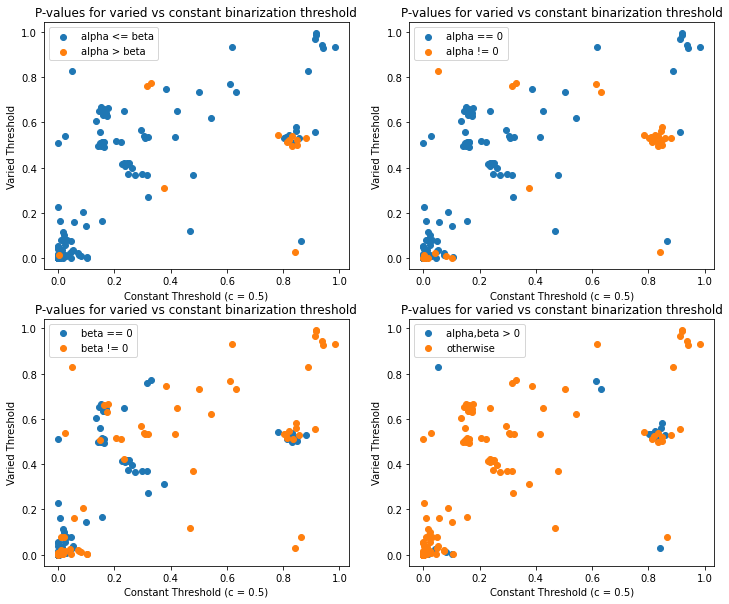

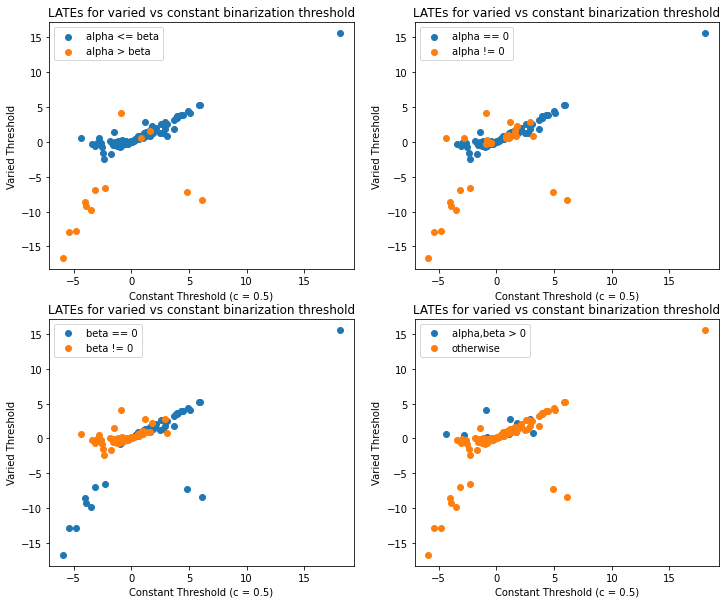

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def show_threshold_method_comparison_plot(statisticname, statisticlabel, alphavbetacondition, alphavbetatruelabel, alphavbetafalselabel, axis=None):
    stats_constant = []
    stats_vary = []
    alphavbeta = []

    for p in ["high", "medium", "low"]:
        for stats,vary in [(stats_constant,False),(stats_vary,True)]:
            df = pd.read_csv("results/results {} priority{}.csv".format(p, " -- varied threshold" if vary else ""))
            stats += list(df[statisticname])

            if vary:
                for i,row in df.iterrows():
                    Z,X,Y = pert_df[row["XZ"]], counts_df[row["XZ"]], counts_df[row["Y"]]
                    X0, X1 = X.loc[Z == 0], X.loc[Z == 1]
                    Y0, Y1 = Y.loc[Z == 0], Y.loc[Z == 1]

                    Nx, Ny = int(X.max()), int(Y.max())
                    FX0, FX1 = getFHat(X0, Nx), getFHat(X1, Nx)
                    FY0, FY1 = getFHat(Y0, Ny), getFHat(Y1, Ny)
                    alpha = getThreshold(FX0, FX1, 0.25, Nx)
                    beta = getThreshold(FY0, FY1, 0.25, Ny)
                    alphavbeta.append(alphavbetacondition(alpha, beta))

    alphavbeta = np.asarray(alphavbeta)
    if axis is None:
        _, axis = plt.subplots(1,1)
    axis.scatter(np.extract(alphavbeta, stats_constant), np.extract(alphavbeta, stats_vary), label=alphavbetatruelabel)
    axis.scatter(np.extract(alphavbeta == False, stats_constant), np.extract(alphavbeta == False, stats_vary), label=alphavbetafalselabel)
    axis.legend()
    axis.set_xlabel("Constant Threshold (c = 0.5)")
    axis.set_ylabel("Varied Threshold")
    axis.set_title("{} for varied vs constant binarization threshold".format(statisticlabel))
    if axis is None:
        plt.show()
    
    
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(12)
show_threshold_method_comparison_plot("LATE_pval", "P-values", lambda a,b: a <= b, "alpha <= beta", "alpha > beta", ax[0,0])
show_threshold_method_comparison_plot("LATE_pval", "P-values", lambda a,b: a == 0, "alpha == 0", "alpha != 0", ax[0,1])
show_threshold_method_comparison_plot("LATE_pval", "P-values", lambda a,b: b == 0, "beta == 0", "beta != 0", ax[1,0])
show_threshold_method_comparison_plot("LATE_pval", "P-values", lambda a,b: a>0 and b>0, "alpha,beta > 0", "otherwise", ax[1,1])
plt.show()


fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(12)
show_threshold_method_comparison_plot("LATE_median", "LATEs", lambda a,b: a <= b, "alpha <= beta", "alpha > beta", ax[0,0])
show_threshold_method_comparison_plot("LATE_median", "LATEs", lambda a,b: a == 0, "alpha == 0", "alpha != 0", ax[0,1])
show_threshold_method_comparison_plot("LATE_median", "LATEs", lambda a,b: b == 0, "beta == 0", "beta != 0", ax[1,0])
show_threshold_method_comparison_plot("LATE_median", "LATEs", lambda a,b: a>0 and b>0, "alpha,beta > 0", "otherwise", ax[1,1])
plt.show()

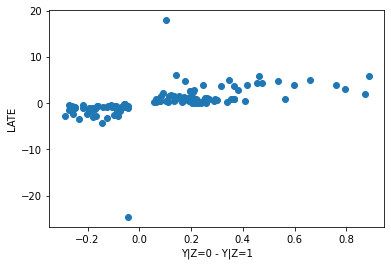

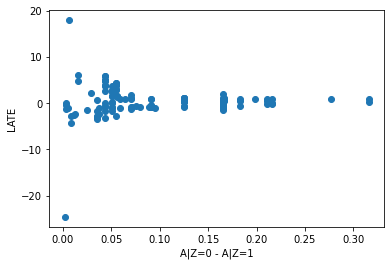

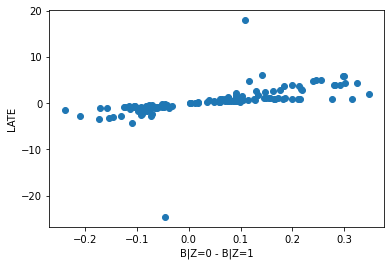

In [30]:
Y_effect = []
A_effect = []
B_effect = []

LATEs = []


for p in ["high", "medium", "low"]:
    df = pd.read_csv("results/results {} priority.csv".format(p))
    for i,row in df.iterrows():
        Z,X,Y = pert_df[row["XZ"]], counts_df[row["XZ"]], counts_df[row["Y"]]
        X0, X1 = X.loc[Z == 0], X.loc[Z == 1]
        Y0, Y1 = Y.loc[Z == 0], Y.loc[Z == 1]
        A0, A1 = (X0 > 0.5).astype(int), (X1 > 0.5).astype(int)
        B0, B1 = (Y0 > 0.5).astype(int), (Y1 > 0.5).astype(int)
        
        if A0.mean()-A1.mean() <= 0:
            continue
        
        LATEs.append(row["LATE_median"])
        Y_effect.append(Y0.mean()-Y1.mean())
        A_effect.append(A0.mean()-A1.mean())
        B_effect.append(B0.mean()-B1.mean())

LATEs = np.asarray(LATEs)

plt.scatter(Y_effect, LATEs)
plt.xlabel("Y|Z=0 - Y|Z=1")
plt.ylabel("LATE")
plt.show()

plt.scatter(A_effect, LATEs)
plt.xlabel("A|Z=0 - A|Z=1")
plt.ylabel("LATE")
plt.show()

plt.scatter(B_effect, LATEs)
plt.xlabel("B|Z=0 - B|Z=1")
plt.ylabel("LATE")
plt.show()